Range compression tamamlandı ✓
Boyut: (256, 512)
Azimuth compression tamamlandı ✓
Boyut: (256, 512)


/tmp/ipykernel_4089061/174198050.py:205: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/home/ahmet/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


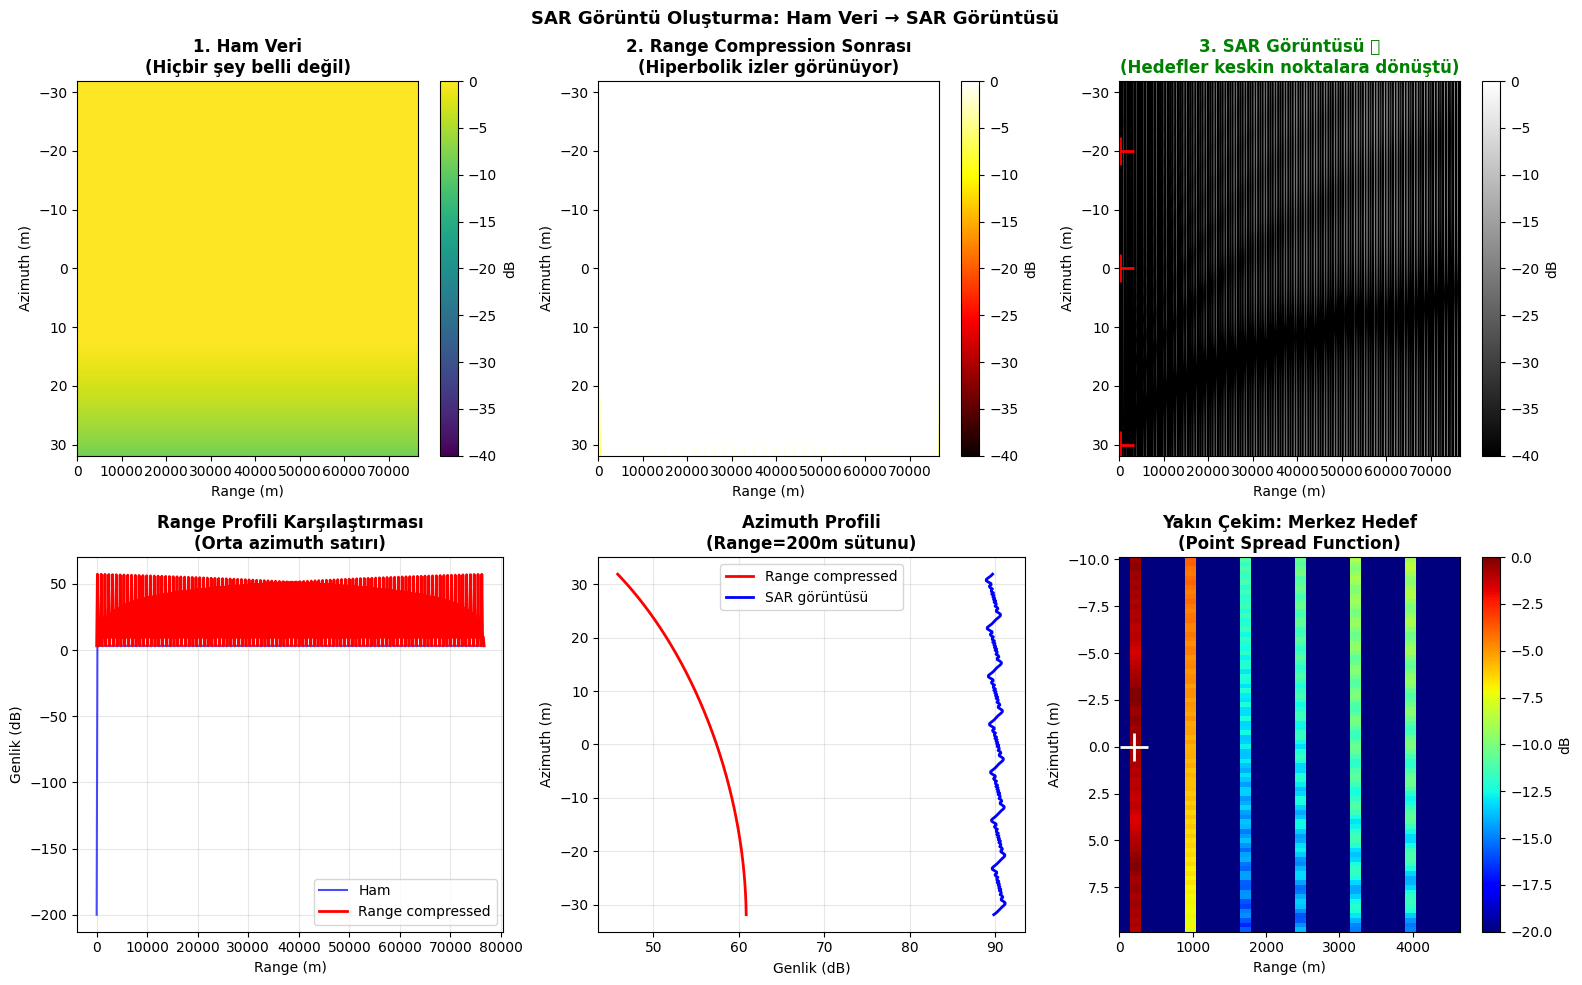


ÇÖZÜNÜRLÜK ÖLÇÜMÜ:
Teorik range çözünürlüğü:   0.75 m
Teorik azimuth çözünürlüğü: 0.05 m
SAR çözünürlüğü (D/2):      0.050 m


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# PARAMETRELER
# ============================================
c = 3e8
f_c = 10e9
lambda_c = c / f_c
B = 200e6
T_chirp = 1e-3
K = B / T_chirp
fs = 1e6
N_range = 512
N_azimuth = 256
v = 50

t_range = np.arange(N_range) / fs
range_axis = np.arange(N_range) * c / (2 * fs)

# Azimuth zaman ekseni
PRF = 200                # Pulse Repetition Frequency
t_az = np.arange(N_azimuth) / PRF
y_platform = v * t_az

# Hedefler
targets = [
    {'range': 200, 'azimuth': 0,   'amp': 1.0},
    {'range': 250, 'azimuth': 30,  'amp': 0.8},
    {'range': 180, 'azimuth': -20, 'amp': 0.7},
]

# ============================================
# HAM VERİ OLUŞTUR
# ============================================
ref_chirp = np.exp(1j * np.pi * K * t_range**2)
raw_data = np.zeros((N_azimuth, N_range), dtype=complex)

for az_idx, yp in enumerate(y_platform):
    for target in targets:
        R_instant = np.sqrt(target['range']**2 +
                           (yp - target['azimuth'])**2)
        delay = 2 * R_instant / c
        delay_samples = int(delay * fs)

        angle = np.arctan2(yp - target['azimuth'], target['range'])
        beamwidth = lambda_c / 0.1
        weight = target['amp'] * np.sinc(angle / beamwidth)

        if delay_samples < N_range:
            delayed = np.zeros(N_range, dtype=complex)
            delayed[delay_samples:] = ref_chirp[:N_range - delay_samples]
            raw_data[az_idx] += weight * delayed

# ============================================
# ADIM 1: RANGE COMPRESSION
# Her satıra matched filter
# ============================================
H_range = np.fft.fft(ref_chirp)
range_compressed = np.zeros_like(raw_data)

for az_idx in range(N_azimuth):
    S = np.fft.fft(raw_data[az_idx])
    range_compressed[az_idx] = np.fft.ifft(S * np.conj(H_range))

print("Range compression tamamlandı ✓")
print(f"Boyut: {range_compressed.shape}")

# ============================================
# ADIM 2: AZIMUTH COMPRESSION
# Her range hücresi için azimuth matched filter
# ============================================

# Her range hücresi farklı R0'a sahip
# Azimuth referans fonksiyonu R0'a bağlı

sar_image = np.zeros_like(range_compressed)

for range_idx in range(N_range):
    # Bu range hücresinin merkez mesafesi
    R0 = range_axis[range_idx]

    if R0 < 1:  # Sıfır mesafeyi atla
        continue

    # Azimuth chirp rate
    Ka = 2 * v**2 / (lambda_c * R0)

    # Azimuth referans fonksiyonu (azimuth chirp)
    h_az = np.exp(-1j * np.pi * Ka * t_az**2)

    # Bu sütunu al (N_azimuth elemanlı dizi)
    column = range_compressed[:, range_idx]

    # Azimuth matched filter uygula
    H_az = np.fft.fft(h_az)
    S_az = np.fft.fft(column)
    sar_image[:, range_idx] = np.fft.ifft(S_az * np.conj(H_az))

print("Azimuth compression tamamlandı ✓")
print(f"Boyut: {sar_image.shape}")

# ============================================
# GÖRSELLEŞTİRME
# ============================================
azimuth_axis = y_platform - y_platform.mean()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Ham veri
ax = axes[0, 0]
im = ax.imshow(20*np.log10(np.abs(raw_data)+1e-10),
               aspect='auto', cmap='viridis',
               vmin=-40, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      azimuth_axis[-1], azimuth_axis[0]])
plt.colorbar(im, ax=ax, label='dB')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('1. Ham Veri\n(Hiçbir şey belli değil)', fontweight='bold')

# 2. Range compressed
ax = axes[0, 1]
im = ax.imshow(20*np.log10(np.abs(range_compressed)+1e-10),
               aspect='auto', cmap='hot',
               vmin=-40, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      azimuth_axis[-1], azimuth_axis[0]])
plt.colorbar(im, ax=ax, label='dB')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('2. Range Compression Sonrası\n(Hiperbolik izler görünüyor)',
             fontweight='bold')

# 3. SAR görüntüsü
ax = axes[0, 2]
sar_db = 20*np.log10(np.abs(sar_image)+1e-10)
sar_db -= sar_db.max()
im = ax.imshow(sar_db, aspect='auto', cmap='gray',
               vmin=-40, vmax=0,
               extent=[range_axis[0], range_axis[-1],
                      azimuth_axis[-1], azimuth_axis[0]])
plt.colorbar(im, ax=ax, label='dB')
for target in targets:
    ax.plot(target['range'], target['azimuth'],
            'r+', markersize=20, markeredgewidth=2)
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('3. SAR Görüntüsü ✅\n(Hedefler keskin noktalara dönüştü)',
             fontweight='bold', color='green')

# 4. Range profili karşılaştırması
ax = axes[1, 0]
mid_az = N_azimuth // 2
ax.plot(range_axis, 20*np.log10(np.abs(raw_data[mid_az])+1e-10),
        'b-', linewidth=1.5, alpha=0.7, label='Ham')
ax.plot(range_axis, 20*np.log10(np.abs(range_compressed[mid_az])+1e-10),
        'r-', linewidth=2, label='Range compressed')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Genlik (dB)')
ax.set_title('Range Profili Karşılaştırması\n(Orta azimuth satırı)',
             fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Azimuth profili karşılaştırması
ax = axes[1, 1]
range_200_idx = np.argmin(np.abs(range_axis - 200))
ax.plot(20*np.log10(np.abs(range_compressed[:, range_200_idx])+1e-10),
        azimuth_axis, 'r-', linewidth=2, label='Range compressed')
ax.plot(20*np.log10(np.abs(sar_image[:, range_200_idx])+1e-10),
        azimuth_axis, 'b-', linewidth=2, label='SAR görüntüsü')
ax.set_xlabel('Genlik (dB)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('Azimuth Profili\n(Range=200m sütunu)',
             fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Tek hedef yakın çekim
ax = axes[1, 2]
r_idx_200 = np.argmin(np.abs(range_axis - 200))
r_start = max(0, r_idx_200 - 30)
r_end = min(N_range, r_idx_200 + 30)
az_center = np.argmin(np.abs(azimuth_axis - 0))
az_start = max(0, az_center - 40)
az_end = min(N_azimuth, az_center + 40)

zoom = np.abs(sar_image[az_start:az_end, r_start:r_end])
zoom_db = 20*np.log10(zoom + 1e-10)
zoom_db -= zoom_db.max()
im = ax.imshow(zoom_db, aspect='auto', cmap='jet',
               vmin=-20, vmax=0,
               extent=[range_axis[r_start], range_axis[r_end],
                      azimuth_axis[az_end], azimuth_axis[az_start]])
plt.colorbar(im, ax=ax, label='dB')
ax.plot(200, 0, 'w+', markersize=20, markeredgewidth=2)
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth (m)')
ax.set_title('Yakın Çekim: Merkez Hedef\n(Point Spread Function)',
             fontweight='bold')

plt.suptitle('SAR Görüntü Oluşturma: Ham Veri → SAR Görüntüsü',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================
# ÇÖZÜNÜRLÜK ÖLÇÜMÜ
# ============================================
print("\n" + "="*55)
print("ÇÖZÜNÜRLÜK ÖLÇÜMÜ:")
print("="*55)
print(f"Teorik range çözünürlüğü:   {c/(2*B):.2f} m")

R0_test = 200
Ka = 2 * v**2 / (lambda_c * R0_test)
az_res_theory = v / (Ka * N_azimuth / PRF)
print(f"Teorik azimuth çözünürlüğü: {az_res_theory:.2f} m")
print(f"SAR çözünürlüğü (D/2):      {0.1/2:.3f} m")
print("="*55)